<a href="https://colab.research.google.com/github/BountyHunter1999/Learning-PyTorch-Notebooks/blob/main/10_PyTorch_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

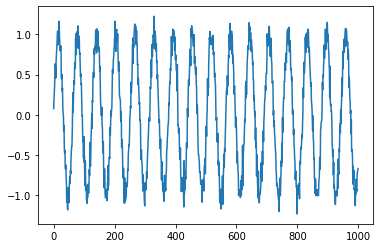

In [61]:
# make the original data
N = 1000
# series = np.sin(0.1 * np.arange(N)) # + np.random.randN(N) * 0.1
series = np.sin(0.1 * np.arange(N))  + np.random.randn(N) * 0.1

# plot it
plt.plot(series)
plt.show()

In [62]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t: t+T] # 0 - 10(not inclusive),1 - 11, 990 - 1000
  X.append(x)
  y = series[t+T]
  Y.append(y)

print(np.array(X).shape)
X = np.array(X).reshape(-1, T) # 990 * 10 
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape} ")

(990, 10)
X.shape: (990, 10), Y.shape: (990, 1) 


In [63]:
### try autoregressive linear model
model = nn.Linear(T, 1)

In [64]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [65]:
N//2, N

(495, 990)

In [66]:
X[:-N//2].shape

(495, 10)

In [67]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [68]:
# Trainig
def full_gd(model,             
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
   
   # stuff to store
   train_losses = np.zeros(epochs)
   test_losses = np.zeros(epochs)

   for it in range(epochs):
     # zero the parameter gradients
     optimizer.zero_grad()

     # Forward pass
     outputs = model(X_train)
     loss = criterion(outputs, y_train)

     # Backward and optimize
     loss.backward()
     optimizer.step()

     # Save losses
     train_losses[it] = loss.item()

     # Test loss
     test_outputs = model(X_test)
     test_loss = criterion(test_outputs, y_test)
     test_losses[it] = test_loss.item()

     if (it + 1) % 5 == 0:
       print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

   return train_losses, test_losses


In [69]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.1554, Test Loss: 0.0618
Epoch 10/200, Train Loss: 0.0699, Test Loss: 0.0218
Epoch 15/200, Train Loss: 0.0683, Test Loss: 0.0401
Epoch 20/200, Train Loss: 0.0628, Test Loss: 0.0480
Epoch 25/200, Train Loss: 0.0421, Test Loss: 0.0379
Epoch 30/200, Train Loss: 0.0261, Test Loss: 0.0265
Epoch 35/200, Train Loss: 0.0215, Test Loss: 0.0231
Epoch 40/200, Train Loss: 0.0203, Test Loss: 0.0209
Epoch 45/200, Train Loss: 0.0183, Test Loss: 0.0181
Epoch 50/200, Train Loss: 0.0171, Test Loss: 0.0167
Epoch 55/200, Train Loss: 0.0170, Test Loss: 0.0165
Epoch 60/200, Train Loss: 0.0167, Test Loss: 0.0159
Epoch 65/200, Train Loss: 0.0163, Test Loss: 0.0154
Epoch 70/200, Train Loss: 0.0160, Test Loss: 0.0151
Epoch 75/200, Train Loss: 0.0158, Test Loss: 0.0150
Epoch 80/200, Train Loss: 0.0155, Test Loss: 0.0148
Epoch 85/200, Train Loss: 0.0153, Test Loss: 0.0148
Epoch 90/200, Train Loss: 0.0152, Test Loss: 0.0148
Epoch 95/200, Train Loss: 0.0151, Test Loss: 0.0147
Epoch 100/200

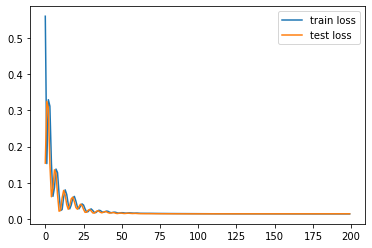

In [70]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [71]:
X_test[0].shape, X_test[0].view(1, -1).shape

(torch.Size([10]), torch.Size([1, 10]))

In [72]:
# 'Wrong' forecast using true targets, NOT TO DO!!!
# we should not use the true values to predict the future values

validation_target = Y[-N//2:] # 2nd half of Y
validation_predictions = []

# index of first validation input 
i = 0

while len(validation_predictions) < len(validation_target):
  # X_test is N x T, so X_test[i] is T, we want it to be 2D 1 * T
  input_ = X_test[i].view(1, -1)

  # model outputs N x K, here N=1 and K=1
  p = model(input_)[0, 0].item() # 1 x 1 array -> scalar
  i +=1

  # update the predictions list
  validation_predictions.append(p)

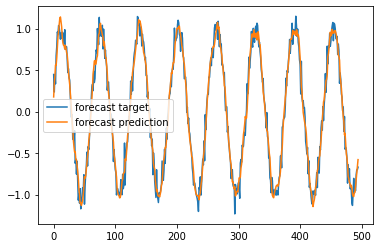

In [73]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [74]:
Y.shape

(990, 1)

In [75]:
-N//2

-495

In [76]:
Y[495]

array([0.44655709])

In [77]:
Y[-N//2]

array([0.44655709])

In [78]:
# Forecast future values (use only self-predictions for making future predictions)
# the correct way!!!
# last_x will be the first input vector and from that 
# we won't take new values from actual dataset

validation_target = Y[-N//2:] # 2nd half of Y
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
  # X_test is N x T, so X_test[i] is T, we want it to be 2D 1 * T
  input_ = last_x.view(1, -1)

  # model outputs N x K, here N=1 and K=1
  p = model(input_) # 1 x 1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0, 0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

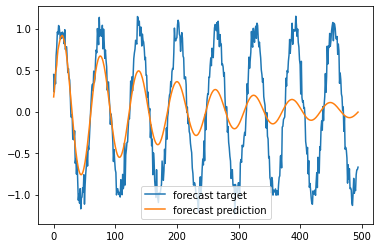

In [79]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()